# Investigating Stabilizers on IQM Star

IQM Star is a QPU architecture, where multiple qubits are connected to a central resonator leading to an effective all-to-all connectivity. It is particularly interesting towards error correction and fault-tolerant quantum computing. 

In this notebook, we will learn how ...
* ... to create stabilizer codes on IQM Star using Qiskit 
* and then apply post selection to retrieve the logical state.

Let's start with the necessary imports. In this example, we will use qiskit.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, transpile
from iqm.qiskit_iqm import IQMCircuit
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


## Connecting to a QPU via IQM Resonance

In order to access a QPU through IQM Resonance, you will need to create an API Token. Go to [resonance.meetiqm.com](https://resonance.meetiqm.com), create and copy the token and store it inside your .env file or set it explicitely as a environment token in th ecell below (or follow the guidelines for your system to create a environment variable).

In [4]:
import os

from dotenv import load_dotenv
load_dotenv()
token = os.getenv("IQM_TOKEN")
os.environ["IQM_TOKEN"] = token

Then we can start again by connecting IQM Resonance and create a `backend` object that we can use later.

In [ ]:
from iqm.qiskit_iqm import IQMProvider
provider = IQMProvider(url="https://cocos.resonance.meetiqm.com/sirius")
backend = provider.get_backend()

Now, let's check out the connectivity map to see the star in its full beauty 😊.

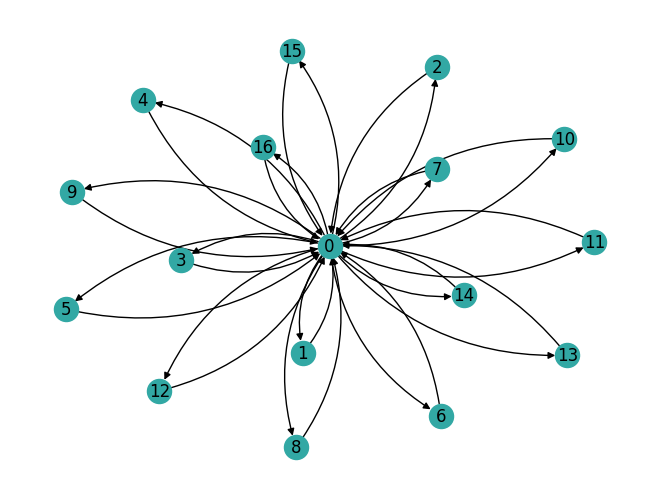

In [6]:
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout
mpl_draw(backend.coupling_map.graph, arrows=True, with_labels=True, node_color='#32a8a4', pos=spring_layout(backend.coupling_map.graph, num_iter=200))

## Creating a stabilizer circuit

Now that we have the connection to a QPU with Star topology, let's use it to run a stabilizer circuit. 
A stabilizer circuit is a quantum circuit designed to implement a set of stabilizer generators, which are operators that define a quantum error-correcting code. These circuits typically involve applying a sequence of Clifford gates, including Hadamard, CNOT, and phase gates, to prepare, measure, and manipulate the encoded quantum information in a way that allows for the detection and correction of errors without destroying the logical qubit.

We will use 6 qubits for our experiments, of which 4 will be used to contain data, whereas 2 will be used as ancilla qubits to measure syndroms.

In [7]:
ancilla_qubits = [1,2]
data_qubits = [3,4,5,6]
Res = 0 # resonator
no_qubits=len(data_qubits)+len(ancilla_qubits)
comp_r = QuantumRegister(1, 'comp_r') # Computational resonator
q = QuantumRegister(no_qubits, 'q') # Qubits 

### Z stabilizer

Z stabilizers are operators used to detect and correct bit-flip errors (X errors) in quantum codes. They are typically composed of tensor products of Pauli-Z and identity operators acting on specific qubits, and they commute with the logical operators of the code. Measuring Z stabilizers projects the quantum state onto an eigenspace corresponding to their ±1 eigenvalues, which provides a syndrome indicating whether and where bit-flip errors have occurred, without collapsing the encoded quantum information. So, by checking which Z stabilizers give a −1 result, we can pinpoint where an X error occurred.


Z stabilizers are a key component in stabilizer codes like the surface code, where they work in tandem with X stabilizers (which detect phase-flip or Z errors) to maintain fault-tolerant quantum computation.


Lets create a circuit that initializes our data qubits. Possible states for each qubits are $\ket{1}$, $\ket{0}$, $\ket{{+}}$ and $\ket{{-}}$. So examples for the four data qubits we will use below include '0000', '1100', '${+}{+}{-}{-}$'.

In [8]:
def state_initialization(qc,data_qubits,state):
    for qubit, state in zip(data_qubits,state):
        match state:
            case '1': 
                qc.x(qubit)
            case '+':
                qc.h(qubit)
            case '-':
                qc.x(qubit)
                qc.h(qubit)
            case'0':
                pass
    qc.barrier()
    return qc

With that in place, we can create the actual **circuit for Z stabilizer error measurement syndromes**: Using Hadamard gates we perform a basis transformation to the X basis, then we apply CZ gates to entangle the data qubits with the ancilla qubits, and finally we measure the ancilla qubits in the X basis. The measurement results will give us the syndromes for the Z stabilizers.

In [9]:
def Z_stabilizer_circuit(qc,Ancilla, data_qubits):
    qc.h(Ancilla) # apply a Hadamard gate on the Z ancilla
    qc.barrier()
    qc.move(Ancilla,Res) # MOVE the ancilla state into the resonator
    for data_qubit in data_qubits:
        qc.cz(Res, data_qubit) # apply CZ gates between data qubits and resonator
    qc.move(Ancilla,Res)  # MOVE resonator state back to the ancilla
    qc.barrier()
    qc.h(Ancilla) # apply again a  Hadamard gate on the Z ancilla
    return qc

With these building blocks in place, the error detection circuit can be build as follows:

In [10]:
def error_detection_circuit(initial_state):
    c = ClassicalRegister(1, 'c') # Classical register, used for the ancilla qubit
    qc = IQMCircuit(comp_r, q,c)
    qc = state_initialization(qc,data_qubits,initial_state) # initialize data qubits
    qc = Z_stabilizer_circuit(qc,ancilla_qubits[0],data_qubits) # execute Z stabilizer protocol
    qc.barrier()
    qc.measure(ancilla_qubits[0],c)
    return qc

Let's take a look at how the circuit looks like.

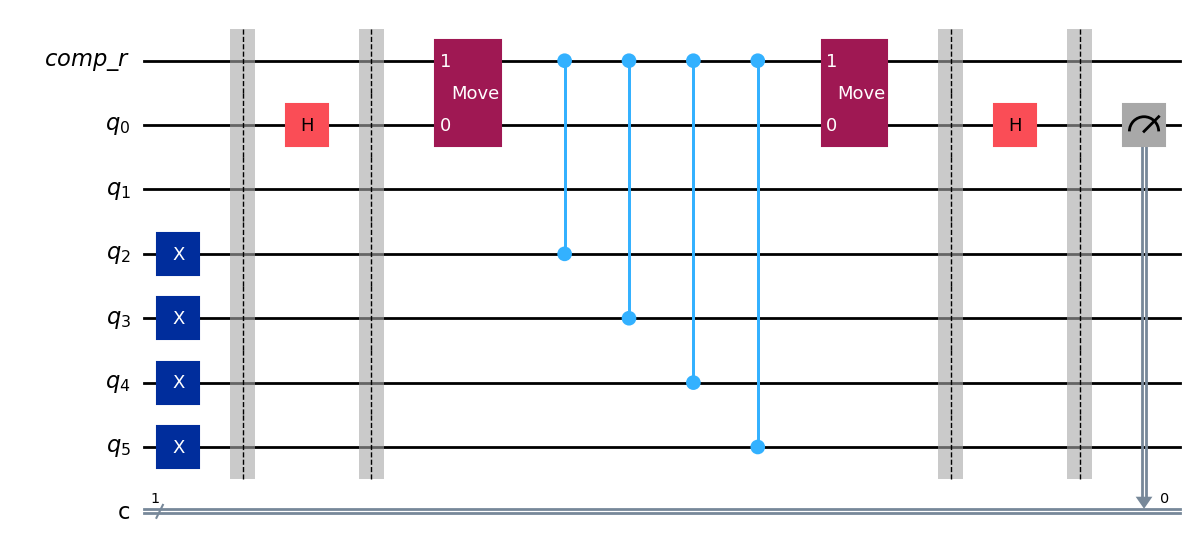

In [11]:
initial_state='1111'
qc=error_detection_circuit(initial_state)
qc.draw("mpl")

The MOVE gat  is used to transfer the state of the ancilla to the computational resonator `comp_r`. Then CZ gates are applied between each data qubits and the `comp_r`. The state is then move back to the ancilla qubit with another MOVE gate. Finally, the state of the ancilla is measured.

In order to run the circuit, we need to transpile it. This will make sure that we only apply operations between physically connected elements (we already took care of this manually), but it will also transpile the Hadamard gates into native single-qubit gates.

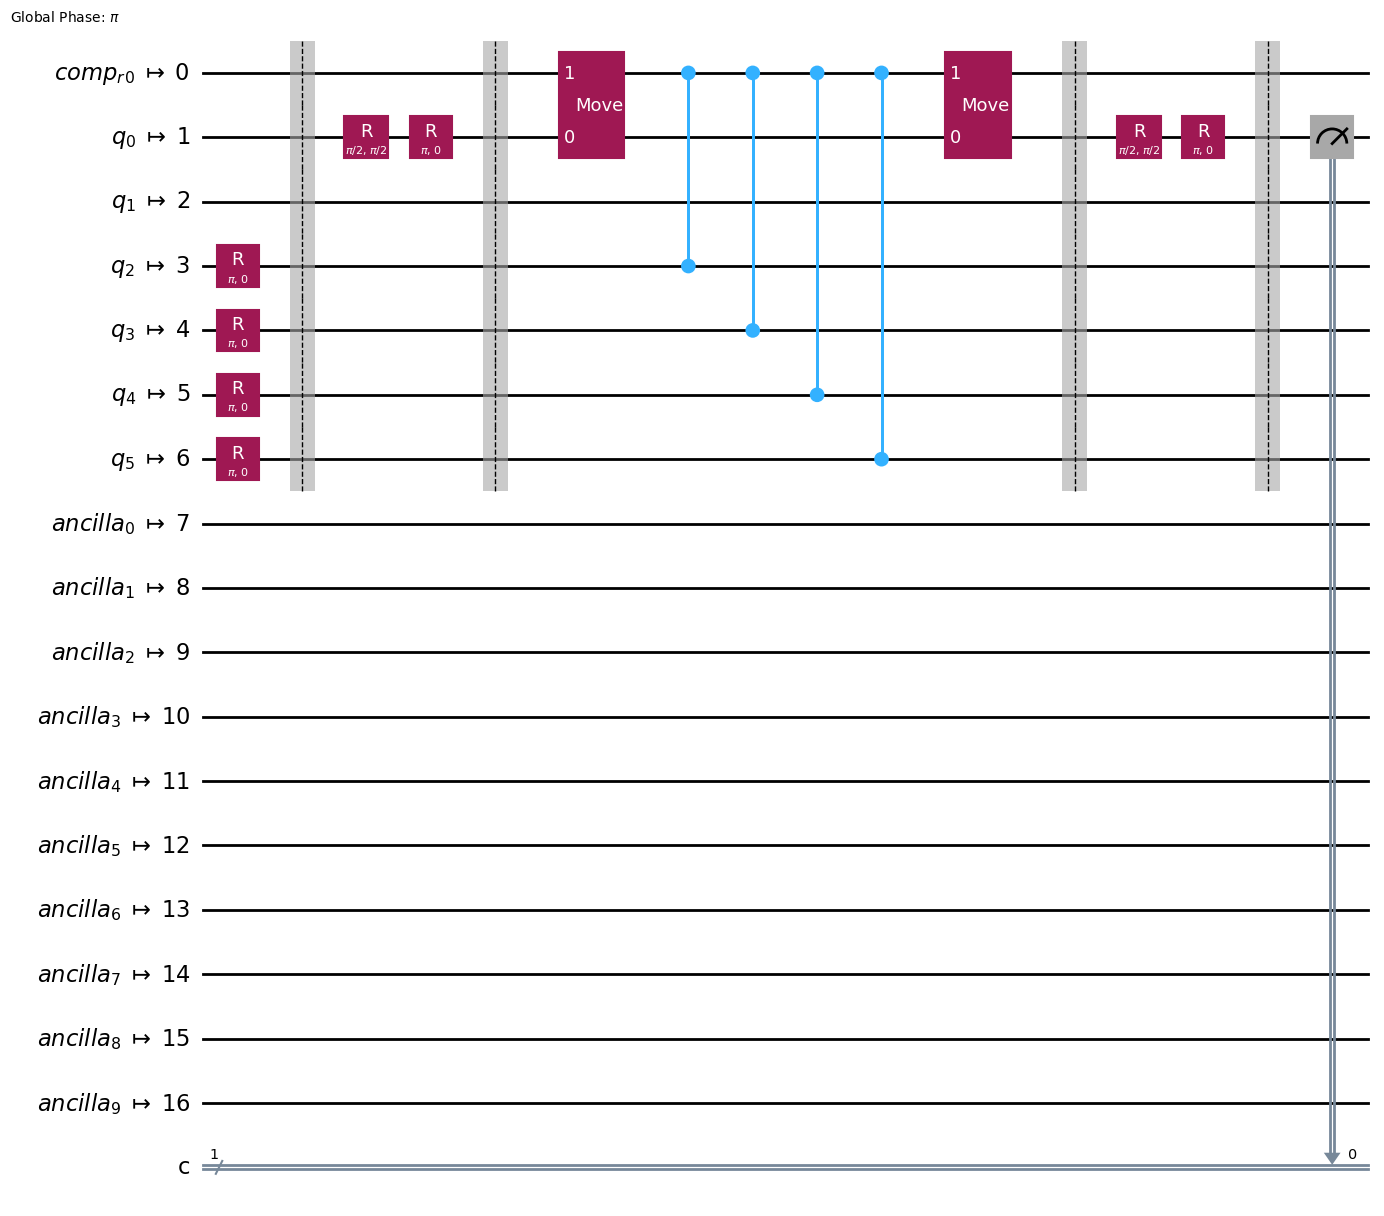

In [12]:
qc=error_detection_circuit(initial_state)
qc_transpiled = transpile(qc, backend)
qc_transpiled.draw("mpl")

### Measureming the Z stabilizer

With the circuit in place, we can now run it on the QPU. We will run the circuit multiple times (for each initial state) to get a good estimate of the measurement outcomes.

In [13]:
Z_initial_states=['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [14]:
# measure stabilizer for various input states 
repetition=1000
Z_stabilizer={}

# Define the circuit:
qc=[error_detection_circuit(initial_state) for initial_state in Z_initial_states] # array of circuit for each initial state

# Measure it
qc_transpiled = transpile(qc, backend)
job = backend.run(qc_transpiled, shots=repetition)
result=job.result()

# Analyse the results
counts=result.get_counts()
for i,initial_state in enumerate(Z_initial_states):
    # Count how often the ancilla is measured in state 1 for each initial state
    counts_Z_stabilizer=sum(value for value,key in zip(list(counts[i].values()), list(counts[i].keys())) if key[0]=='1')
    Z_stabilizer[initial_state]=counts_Z_stabilizer

Plotting the results shows us that for even states (e.g. '0000') the ancilla state is 0 while for odd states (e.g. '0001') the ancilla state is 1 most of the time. This is how we can do parity state measurement and use it to detect error.

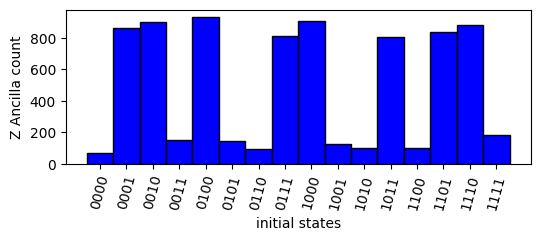

In [15]:
plt.subplots(figsize=(6, 2))
plt.bar(list(Z_stabilizer.keys()),list(Z_stabilizer.values()), width=1,edgecolor='black',color='b',align='center')
plt.xlabel('initial states')
plt.ylabel('Z Ancilla count')
plt.tick_params(axis="x", labelrotation=75)


### Creating X stabilizer circuits

We can do the same for X stabilizers. The circuit is very similar, but we need to apply Hadamard gates to the data qubits before and after the CZ gates. This will transform the X stabilizers into Z stabilizers, which we can then measure in the same way as before.

In [16]:
def X_stabilizer_circuit(qc,Ancilla, data_qubits):
    qc.h(Ancilla) # Apply Hadamard gate to the X ancilla
    for data_qubit in data_qubits:
        qc.h(data_qubit) #Apply Hadamard gate to all data qubits
    qc.barrier()
    qc.move(Ancilla,Res) # MOVE ancilla state into the resonator
    for data_qubit in data_qubits:
        qc.cz(Res, data_qubit) # CZ gate between data qubits and resonator
    qc.move(Ancilla,Res) # MOVE resonator state back to ancilla
    qc.barrier()
    for data_qubit in data_qubits:
        qc.h(data_qubit) #Apply Hadamard gate to all data qubits
    qc.h(Ancilla) #Apply Hadamard gate to the X ancilla
    return qc

The full circuit can be created like so:

In [17]:
# Create Quantum Registers and Quantum Circuit
def error_detection_circuit(initial_state):
    c = ClassicalRegister(1, 'c') # Classical register, for the ancilla qubit
    qc = IQMCircuit(comp_r, q,c)
    qc = state_initialization(qc,data_qubits,initial_state) #initialize data qubit
    qc = X_stabilizer_circuit(qc,ancilla_qubits[1],data_qubits) # execute Z stabilizer protocol
    qc.barrier()
    qc.measure(ancilla_qubits[1],c)
    return qc

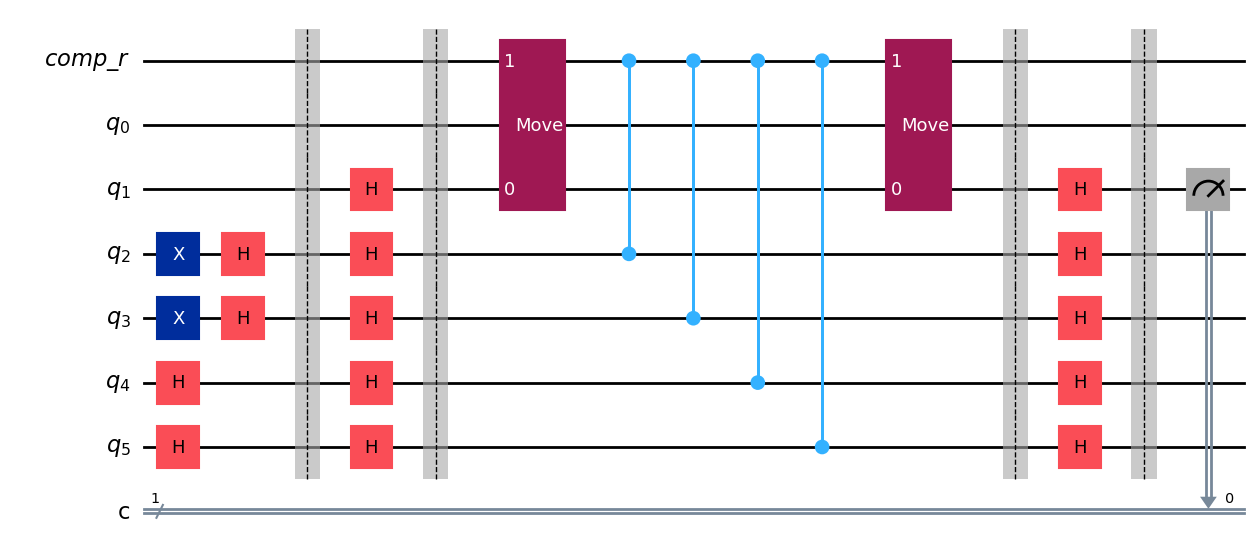

In [18]:
initial_state='--++'
qc=error_detection_circuit(initial_state)
qc.draw("mpl")

The X stabilizer circuit is similar to the Z stabilizer circuit, except that the state of every data qubit is rotated with an Hadamard gate at the begining and at the end of the circuit. 

(In above example, we have additionally initialized the circuit with an initial state in the X-basis using Hadamard and X gates at the beginning.) 

#### Measurement

In [19]:
X_initial_states=['++++', '+++-', '++-+', '++--', '+-++', '+-+-', '+--+', '+---', '-+++', '-++-', '-+-+', '-+--', '--++', '--+-', '---+', '----']
# or
#X_initial_states =[''.join('+' if x==0 else '-' for x in i) for i in itertools.product([0, 1], repeat=4)]

In [20]:
# measure stabilizer for various input states 
repetition=1000
X_stabilizer={}

# Define the circuit:
qc=[error_detection_circuit(initial_state) for initial_state in X_initial_states]

# Measure it
qc_transpiled = transpile(qc, backend)
job = backend.run(qc_transpiled, shots=repetition)
result=job.result()

# Analyse the results
counts=result.get_counts()
for i,initial_state in enumerate(X_initial_states):
    # Count how often the ancilla is measured in state 1 for each initial state
    counts_X_stabilizer=sum(value for value,key in zip(list(counts[i].values()), list(counts[i].keys())) if key[0]=='1')
    X_stabilizer[initial_state]=counts_X_stabilizer


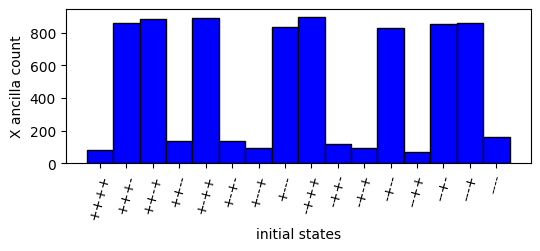

In [21]:
plt.subplots(figsize=(6, 2))
plt.bar(list(X_stabilizer.keys()),list(X_stabilizer.values()), width=1,edgecolor='black',color='b',align='center')
plt.xlabel('initial states')
plt.ylabel('X ancilla count')
plt.tick_params(axis="x", labelrotation=75)

### Z and X stabilizer circuit

Now that we have the individual building blocks in place, we can combine them to create a full stabilizer circuit. This circuit will measure both Z and X stabilizers, which will allow us to detect and correct both bit-flip and phase-flip errors.

We will first measure the Z stabilizer and then continue with measuring the X stabilizer. Note that this time, we will also make use of both ancilla qubits. 

In [22]:
def error_detection_circuit(initial_state):
    c = ClassicalRegister(2, 'c') # Classical register, for the 2 ancilla qubits
    qc = IQMCircuit(comp_r, q,c)
    qc = state_initialization(qc,data_qubits,initial_state) #initialize data qubit
    qc.barrier()
    qc = Z_stabilizer_circuit(qc,ancilla_qubits[0],data_qubits) # execute X stabilizer protocol
    qc = X_stabilizer_circuit(qc,ancilla_qubits[1],data_qubits) # execute Z stabilizer protocol
    qc.barrier()
    qc.measure(ancilla_qubits,c)

    return qc

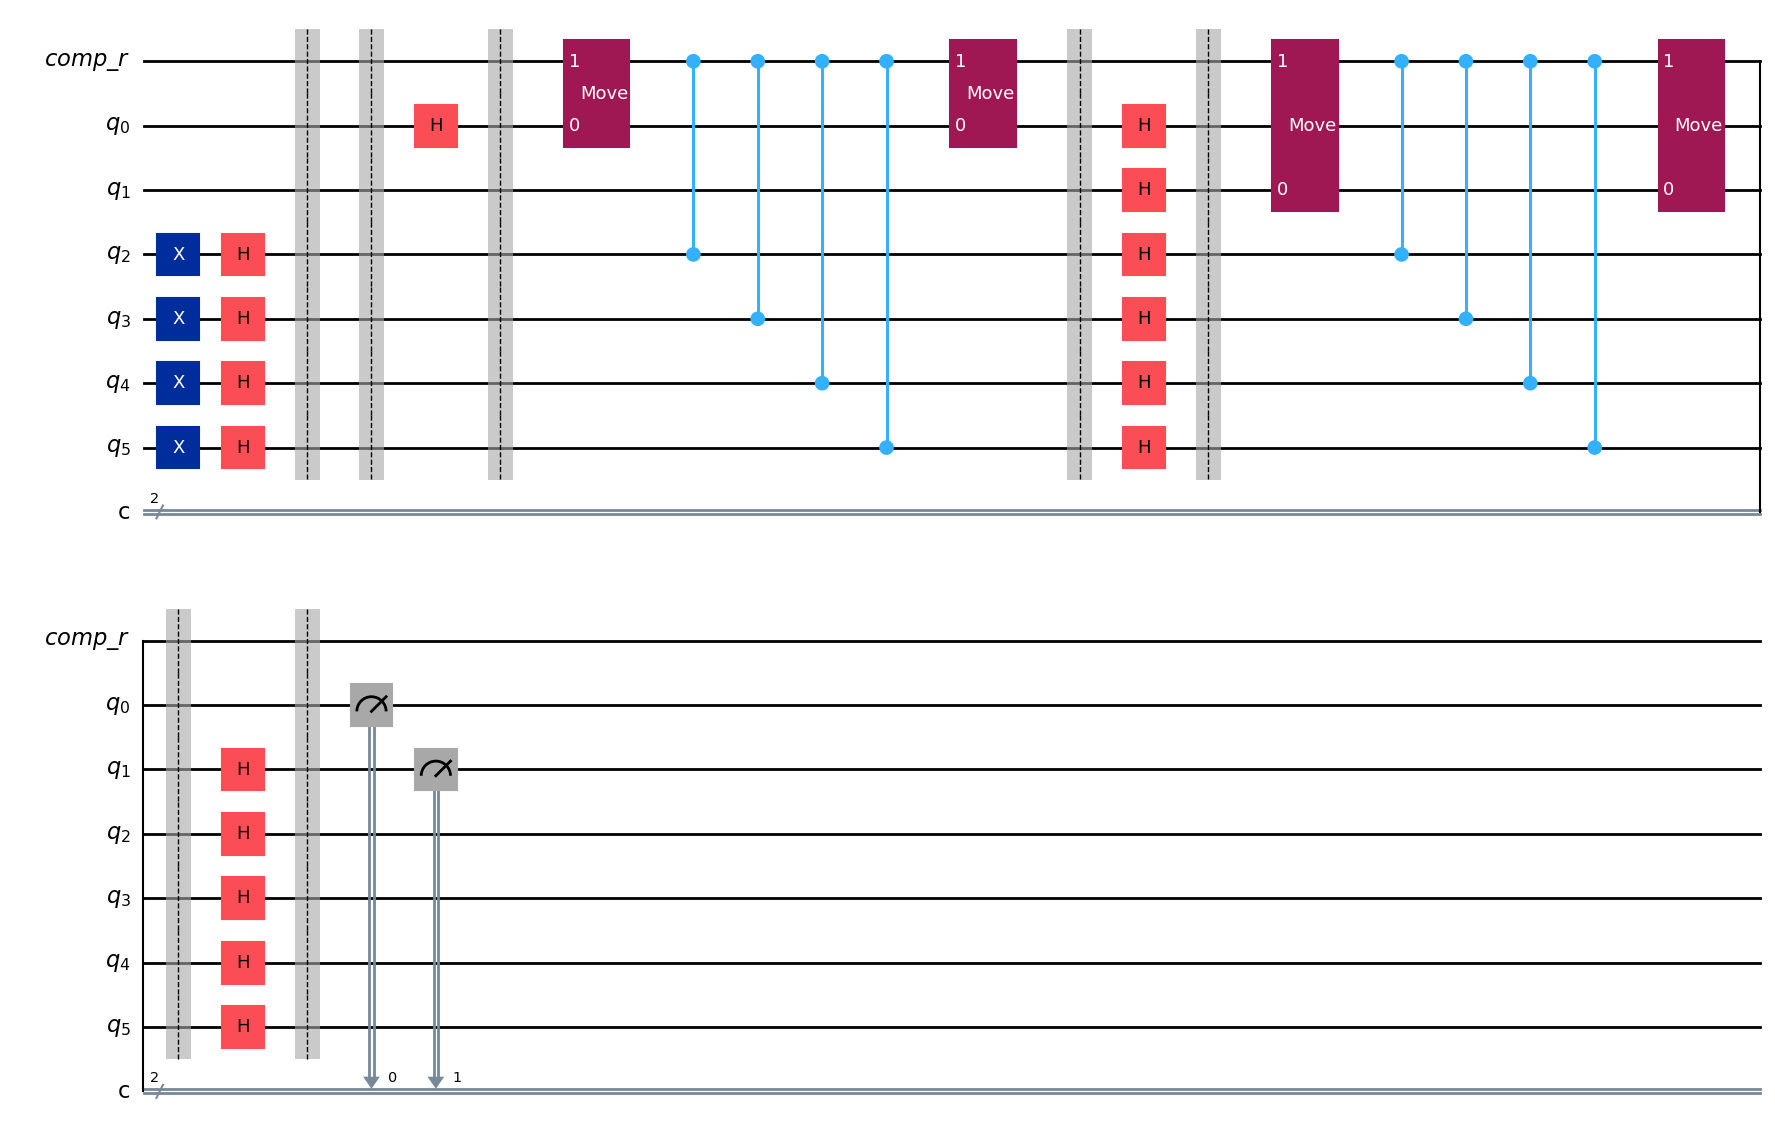

In [23]:
initial_state='----'
qc=error_detection_circuit(initial_state)
qc.draw("mpl")

Again, we want to run the circuit multiple times to get a good estimate of the measurement outcomes.

In [24]:
initial_states=Z_initial_states+X_initial_states

In [25]:
# measure stabilizer for various input states 
repetition=1000
X_stabilizer={}
Z_stabilizer={}
#circuit:
qc=[error_detection_circuit(initial_state) for initial_state in initial_states]

#measure
qc_transpiled = transpile(qc, backend)
job = backend.run(qc_transpiled, shots=repetition)
result=job.result()

#analyse
counts=result.get_counts()
for i,initial_state in enumerate(initial_states):
    counts_Z_stabilizer=sum(value for value,key in zip(list(counts[i].values()), list(counts[i].keys())) if key[1]=='1')
    counts_X_stabilizer=sum(value for value,key in zip(list(counts[i].values()), list(counts[i].keys())) if key[0]=='1')
    X_stabilizer[initial_state]=counts_X_stabilizer/repetition
    Z_stabilizer[initial_state]=counts_Z_stabilizer/repetition

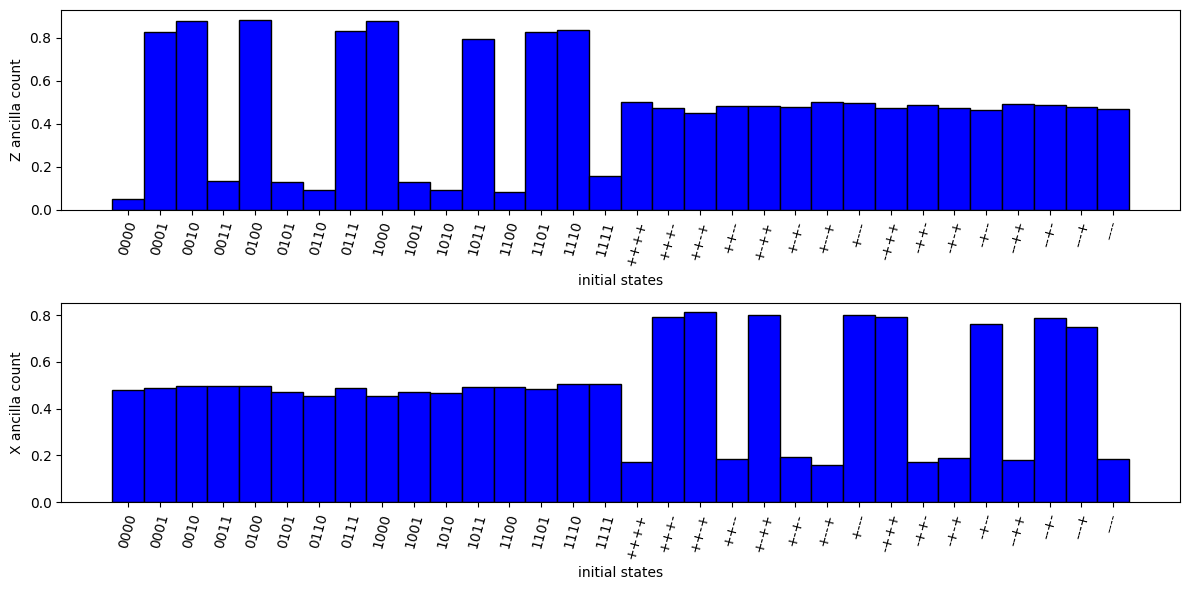

In [26]:
fig, axs = plt.subplots(2,1,figsize=(12,6))

axs[0].bar(list(Z_stabilizer.keys()),list(Z_stabilizer.values()), width=1,edgecolor='black',color='b',align='center')
axs[0].set_xlabel('initial states')
axs[0].set_ylabel('Z ancilla count')
axs[0].tick_params(axis="x", labelrotation=75)

axs[1].bar(list(X_stabilizer.keys()),list(X_stabilizer.values()), width=1,edgecolor='black',color='b',align='center')
axs[1].set_xlabel('initial states')
axs[1].set_ylabel('X ancilla count')
axs[1].tick_params(axis="x", labelrotation=75)
plt.tight_layout() 

#### Logical states

Have you wondered at this point, what does a logical state looks like when encoded in data qubits? Let's add data qubits measurements at the end of the circuit to find out!

In [27]:
# Create Quantum Registers and Quantum Circuit
def error_detection_circuit(initial_state):
    c_data = ClassicalRegister(len(data_qubits), 'cd') # Classical register, for the data qubits
    c_ancilla=ClassicalRegister(len(ancilla_qubits), 'ca') # Classical register, for the ancilla qubits
    qc = IQMCircuit(comp_r, q,c_data,c_ancilla)
    qc = state_initialization(qc,data_qubits,initial_state) # initialize data qubit
    qc.barrier()
    qc = Z_stabilizer_circuit(qc,ancilla_qubits[0],data_qubits) # execute X stabilizer protocol
    qc = X_stabilizer_circuit(qc,ancilla_qubits[1],data_qubits) # execute Z stabilizer protocol
    qc.barrier()
    qc.measure(ancilla_qubits,c_ancilla)
    qc.measure(data_qubits,c_data) # here re add the data qubit measurement.

    return qc

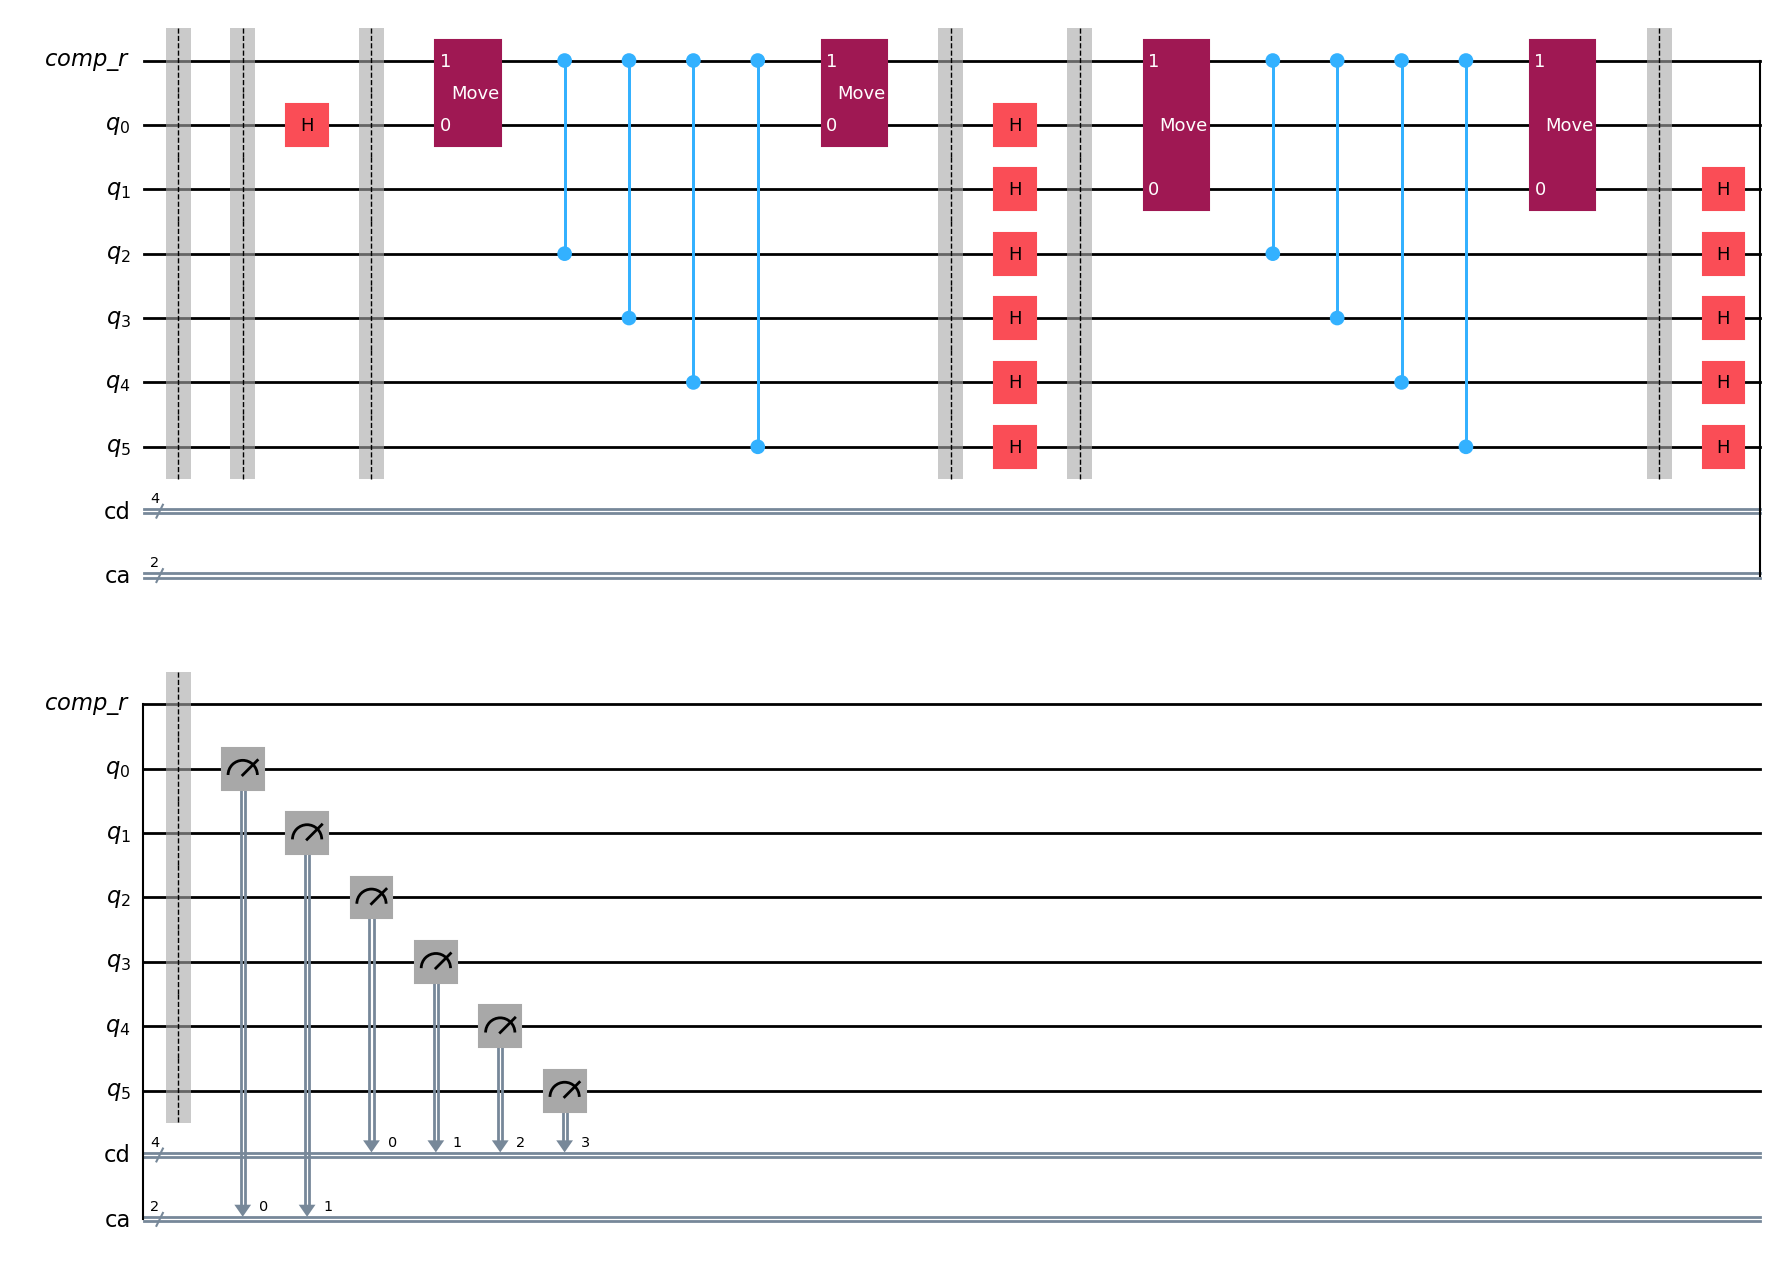

In [28]:
initial_state='0000'
qc=error_detection_circuit(initial_state)
qc.draw("mpl")

#### Measurement

In [29]:
initial_state='0000'

This is how the logical states $\ket{xy}_L$ look like when encoded in the data qubits. This encoding is not achieved by the state preparation alone but is the result of how the stabilizers work.  
- $\ket{00}_L = \left ( \ket{0000}+\ket{1111} \right ) /2 $
- $\ket{01}_L = \left(\ket{0011}+\ket{1100}\right )/\sqrt{2} $
- $\ket{10}_L = \left(\ket{0101}+\ket{1010}\right )/\sqrt{2} $
- $\ket{11}_L = \left(\ket{1001}+\ket{0110}\right )/\sqrt{2}$

- $\ket{{+}{+}}_L =\left (\ket{{+}{+}{+}{+}}+\ket{{-}{-}{-}{-}}\right )/\sqrt{2}$
- $\ket{{+}{-}}_L = \left(\ket{{+}{-}{+}{-}}+\ket{{-}{+}{-}{+}}\right )/\sqrt{2}$
- $\ket{{-}{+}}_L = \left(\ket{{+}{+}{-}{-}}+\ket{{-}{-}{+}{+}}\right )/\sqrt{2}$
- $\ket{{-}{-}}_L = \left(\ket{{-}{+}{+}{-}}+\ket{{+}{-}{-}{+}}\right )/\sqrt{2}$

And indeed, we can see these logical states when applying the full `error_detection_circuit` and measuring the data qubits at the end.

In [30]:
#measure
qc=error_detection_circuit(initial_state)
qc_transpiled = transpile(qc, backend)
job = backend.run(qc_transpiled, shots=repetition)
result=job.result()

#analyze
counts=result.get_counts()
count_physical_state={}
for state in Z_initial_states:
    # extract the count of the physical qubits
    count_physical_state[state]=sum(value for value,key in zip(list(counts.values()), list(counts.keys())) if key[3:7]==state)

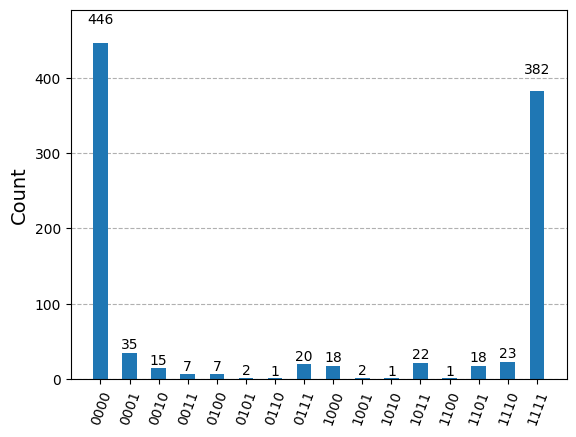

In [31]:
plot_histogram(count_physical_state)

Okay, it is easy to spot the logical state in above histogram. But what if we have errors in our circuit? Let's introduce some errors and see how the logical state changes. For this, we repeat the circuit a multiple `number_of_cycles` times. For sure, we will see more errors accumulating with this longer circuit.

In [32]:
def error_detection_circuit(initial_state, number_of_cycles):

    qc = IQMCircuit(comp_r, q) # no classical register defined yet
    
    qc = state_initialization(qc,data_qubits,initial_state) # initialize data qubits


    for cycle_idx in range(int(number_of_cycles)):
        
        # add classical register
        c_ancilla = ClassicalRegister(len(ancilla_qubits), f"round_{cycle_idx}")
        qc.add_register(c_ancilla)
    
    
        # measurement of ancilla qubits using each register
        qc.barrier()
        qc = Z_stabilizer_circuit(qc,ancilla_qubits[0],data_qubits) # execute X stabilizer protocol
        qc = X_stabilizer_circuit(qc,ancilla_qubits[1],data_qubits) # execute Z stabilizer protocol
        qc.barrier()
        qc.measure(ancilla_qubits,c_ancilla)

    # measurement of data qubits at the end
    c_data = ClassicalRegister(len(data_qubits), "data qubits")
    qc.add_register(c_data)
    qc.measure(data_qubits,c_data)
    return qc

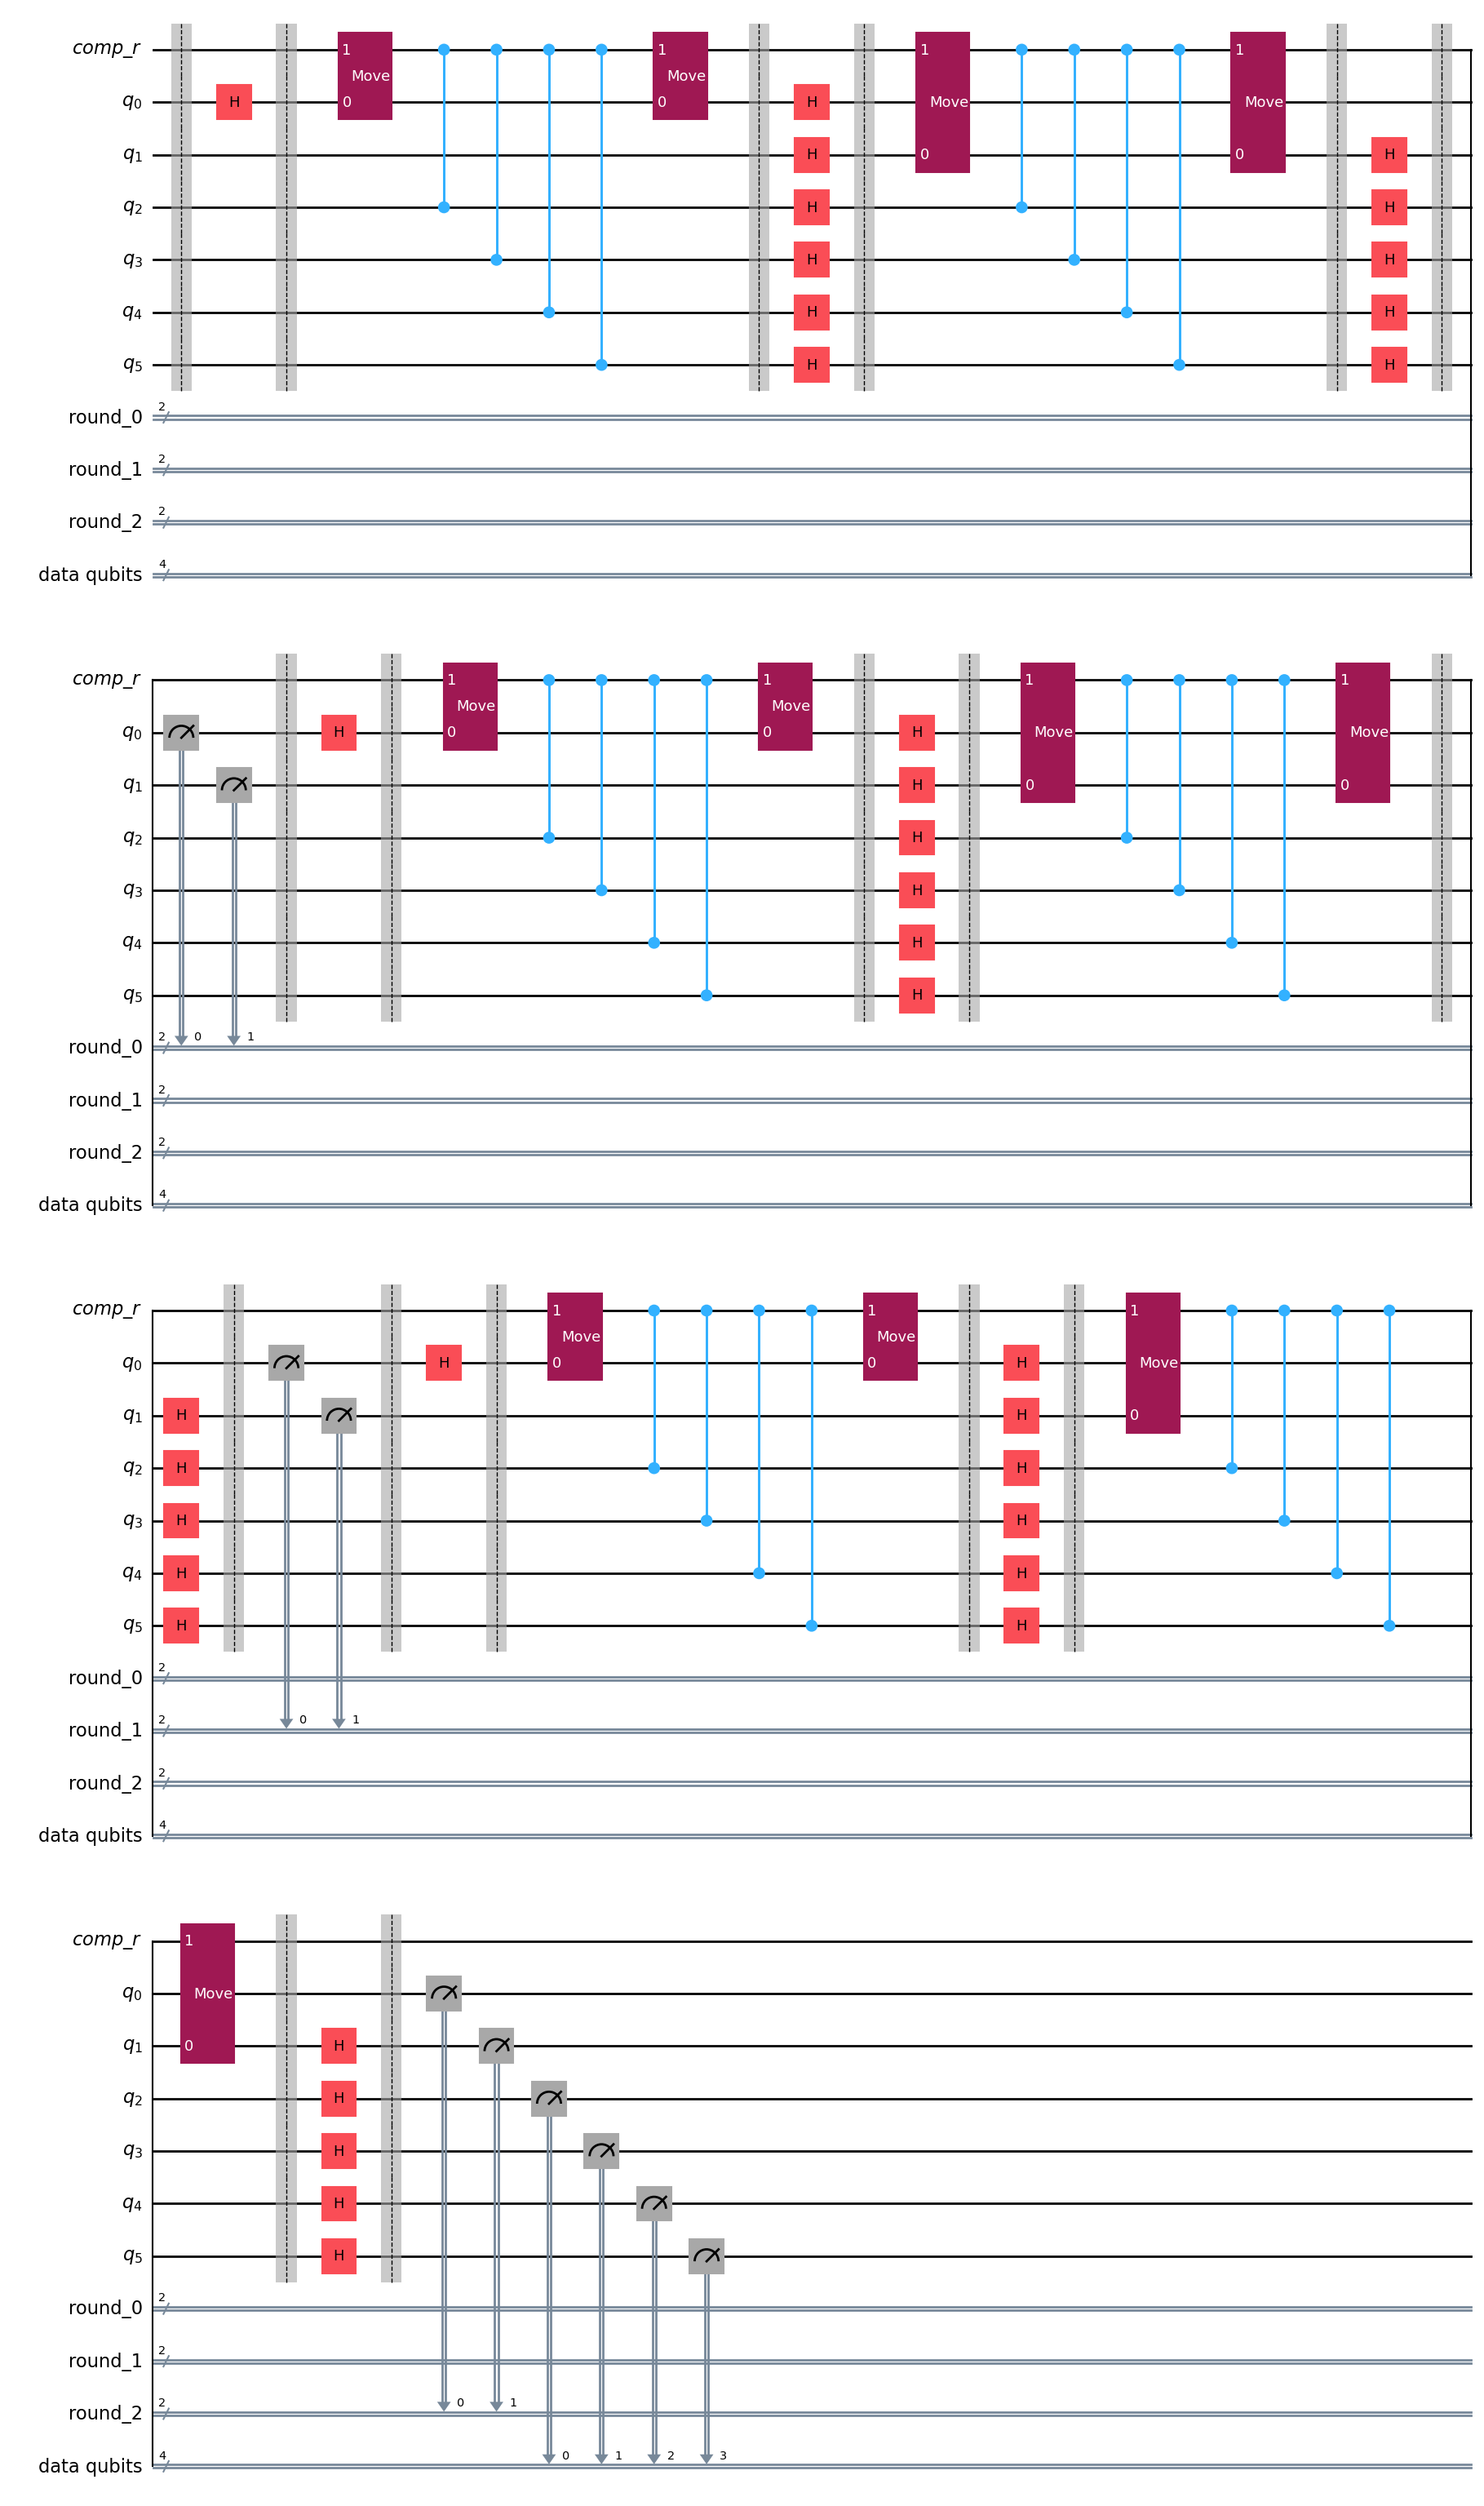

In [33]:
initial_state='0000'
qc=error_detection_circuit(initial_state, 3)
qc.draw("mpl")

Let's retrieve the measurement of the data qubits for one `initital_state` and plot it.

In [34]:
initial_state='0000'
number_of_cycles=3
qc=error_detection_circuit(initial_state,number_of_cycles)
qc_transpiled = transpile(qc, backend)
job = backend.run(qc_transpiled, shots=repetition)
result=job.result()

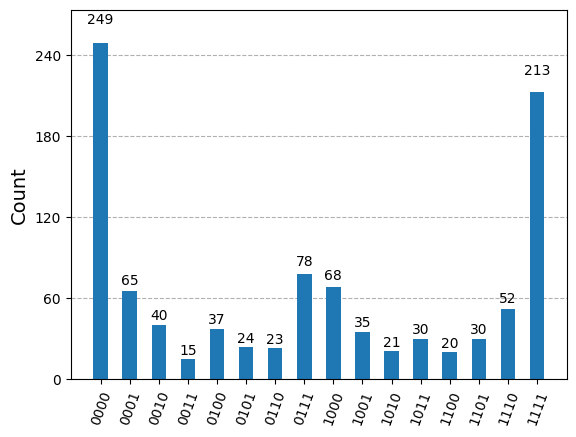

In [35]:
#analyze
counts=result.get_counts()
count_physical_state={}
for state in Z_initial_states:
    #extract the coount fo the physical qubits
    count_physical_state[state]=sum(value for value,key in zip(list(counts.values()), list(counts.keys())) if key[0:len(data_qubits)]==state)
plot_histogram(count_physical_state)

Okay, this looks much more noisy. But we can still see the logical state. Let's see how we can use the syndromes to correct the errors and retrieve the logical state. We will not do this live here, but using post selection. 

### Post selection using the ancilla qubits results

Essentially, the idea is that we remove all measurement results where we find an ancilla in state 1.

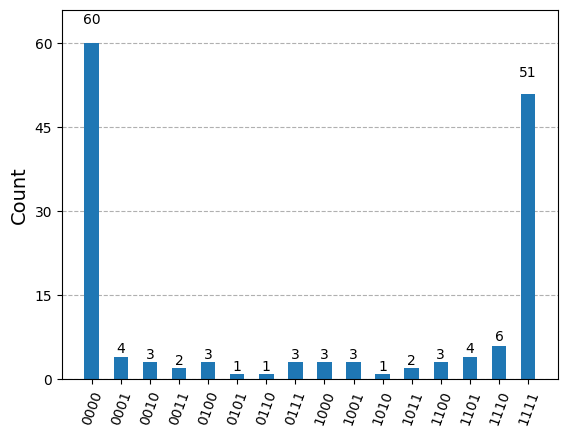

In [36]:
count_physical_state={}
for state in Z_initial_states:
    count_physical_state[state]=sum(value for value,key in zip(list(counts.values()), list(counts.keys())) if key[0:len(data_qubits)]==state 
                                    and not '1' in key[len(data_qubits)+1:])
plot_histogram(count_physical_state)

While we loose a lot of the measurement results because one of the ancillas was measured in state 1, we can see that the logical state is again clearer visible than before applying post selection 🎉.

In [ ]:

# Copyright 2024 IQM Quantum Computers (Florian Vigneau, Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.